# Apples and Oranges

<blockquote>Вы удивились бы, если бы вследствие каких-нибудь обстоятельств на яблонях и апельсинных деревьях вместо плодов вдруг выросли лягушки и ящерицы...

*You would be surprised if, due to some circumstance, frogs and lizards suddenly grew on apple and orange trees instead of fruit...*

Anton Chekov, *The Bet* (*Пари*), 1888</blockquote>

<center><figure><img src="https://drive.google.com/uc?id=1AJARLkRsKVMKZ97S0vYXPKwQ401rVFSa" width="550px" alt="Pommes et oranges: Paul Cézanne, ca 1899"/><figcaption><i>Pommes et oranges</i>: Paul Cézanne, ca 1899.</figcaption>
</figure></center>

“Comparing apples and oranges” is an idiom for comparing two things that are so different that they are not comparable, but are they really very different? Both are fruits, typically similar in sizes, both are widely eaten and generally enjoyed.  Truly incomparable things would be, for example, apples and jet liners, or oranges and the number 12.

It's not trivially easy for a computer to tell the difference between pictures of apples and oranges, and even a basic AI task like this requires some sophisticated programming and machine learning.
 
With [Jina's CLIP-as-service](https://clip-as-service.jina.ai/?utm_source=notebook-cas-apples), all the programming and training are already done! All you need to build a basic classifier is [Jina](https://jina.ai/?utm_source=notebook-cas-apples), a bit of Python, and your own natural language skills.



# Getting Started
First, install [DocArray](https://docarray.jina.ai/?utm_source=notebook-cas-apples) and the [CLIP-as-service client](https://clip-as-service.jina.ai/user-guides/client/?utm_source=notebook-cas-apples).

**⚠️ You _may_ be asked to "Restart Runtime" after this step. If you are, please click the button and restart the runtime.**

In [ ]:
!pip install clip_client docarray

**If you have access to the CaS demo server**, set the value of the variable `cas_server_url` to `grpcs://demo-cas.jina.ai:2096`.

In [ ]:
cas_server_url = 'grpcs://demo-cas.jina.ai:2096'

**If you do not have access to the CaS demo server**, you can run CLIP-as-service in a Google Colab notebook by following the instructions on [this page](https://colab.research.google.com/github/jina-ai/clip-as-service/blob/main/docs/hosting/cas-on-colab.ipynb).  Make sure you get the URL including port number of the server, as instructed on that page, and then come back here, uncomment the line below, and set the value of the variable `cas_server_url` to whatever URL you got from that notebook.  It should look like:

```
<one or two digits>.tcp.ngrok.io:<four or five digits>
```



In [ ]:
# replace '6.tcp.ngrok.io:18096' with the server info from the other notebook,
# then uncomment and run the line below:
# cas_server_url = 'grpc://6.tcp.ngrok.io:18096' 

Finally, create a CLIP-as-service client.

In [ ]:
from clip_client import Client

client = Client(server=cas_server_url, asyncio=True)

# Download data

We have prepared a dataset consisting of photos of apples and oranges from the [Fruits and Vegetables Image Recognition Dataset on Kaggle](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition?utm_source=notebook-cas-apples).

You can download this directly from Jina Hub into a [DocumentArray](https://docarray.jina.ai/fundamentals/documentarray/index.html?utm_source=notebook-cas-apples) object like this:

In [ ]:
from docarray import DocumentArray, Document

apples_and_oranges = DocumentArray.pull("apples_and_oranges", show_progress=True)
print("Done loading!")

The entire dataset is 143 MB and may take up to a minute to download.

A [DocumentArray](https://docarray.jina.ai/?utm_source=notebook-cas-apples) is a container for different kinds of objects and acts much like a list.

In [ ]:
len(apples_and_oranges)

176

This should be 176 documents, each containing an image of one or more apples or oranges and a label that is either 'apple' or 'orange'.

Let's set up some code to look at the individual images stored in the `DocumentArray` object `apples_and_oranges`:

In [ ]:
from IPython.display import Image

def show_image(doc):
  fmt = None
  if doc.mime_type and doc.mime_type.startswith("image/"):
    fmt = doc.mime_type[6:].strip()
  display(Image(data=doc.blob, width=250, format=fmt))
  print(f"Label: {doc.tags['value']}")


The function `show_image()` lets you look at the contents of `apples_and_oranges`:

In [ ]:
show_image(apples_and_oranges[0])

In [ ]:
show_image(apples_and_oranges[100])

# Using CLIP-as-service to classify images

We can use the CLIP-as-service to identify which images are of apples and which are of oranges, without any complex machine learning programming.



CLIP-as-service is able to compare images to text statements, and decide which statement best characterises the image.

Let's take one image as an example.

In [ ]:
pic = apples_and_oranges[52]
show_image(pic) 

You should see a picture of an orange above.

Now, lets construct a query against the CLIP-as-service server.  We will ask it to decide which of the following statements best describes this image:

* *This is an orange.*
* *This is an apple.*

CLIP-as-service queries take the form of a [Document](https://docarray.jina.ai/fundamentals/document/?utm_source=notebook-cas-apples) object from the `DocumentArray` library:

In [ ]:
from docarray import Document

query = Document(
    blob=pic.blob,
    matches=[
        Document(text="This is an apple"),
        Document(text="This is an orange"),
    ],
)

Then, we send the query to the CLIP-as-service server, using the client we created before.  It returns a `DocumentArray` object, containing one `Document` for each document we transmitted to the server.

Since we only sent one `Document` to the server, we only get one `Document` back.

In [ ]:
result = client.rank([query])
print(len(result))

We can see in the `Document` object that score information has been attached to each sentence.

In [ ]:
result[0]

Let's define a function to tabulate this into an easier-to-read result:

In [ ]:
def show_scores(result_document):
  print("Score     \tText")
  print("----------\t----------")
  for proposed_match in result_document.matches:
    print("{:.8f}".format(proposed_match.scores['clip_score'].value) + "\t" + proposed_match.text)

Now let's apply it to the result we got from CLIP:

In [ ]:
show_scores(result[0])

We can see that CLIP is clearly indicating that "This is an orange" better characterises this image than "This is an apple" does.

In this case, it works about as well if we dispense with the "this is a..." part of the query:

In [ ]:
query = Document(
    blob=pic.blob,
    matches=[
        Document(text="apple"),
        Document(text="orange"),
    ],
)

result = client.rank([query])

show_scores(result[0])

We can do this for any image in `apples_and_oranges`:

In [ ]:
def is_it_apple_or_orange(doc):
  query = Document(
    blob=doc.blob,
    matches=[
        Document(text="apple"),
        Document(text="orange"),
    ],
  )
  result = client.rank([query])
  best_match = result[0].matches[0] # the matches are reordered from best to worst by the server
  show_image(doc)
  print(f"Best match: {best_match.text}")
  print(f"Score: {best_match.scores['clip_score'].value}")

is_it_apple_or_orange(apples_and_oranges[12])

Try it with other images from `apples_and_oranges`.

In [ ]:
is_it_apple_or_orange(apples_and_oranges[58])
is_it_apple_or_orange(apples_and_oranges[23])
is_it_apple_or_orange(apples_and_oranges[31])


**Accuracy of CLIP**

We can check how well CLIP can tell the difference between apples and oranges by processing all of the images in `apples_and_oranges`.

Let's create a function to do that.

In [ ]:
def clip_classifier(data, matches):
  # first we break the data into batches of ten
  batches = [data[i:i+10] for i in range(0, len(data), 10)]

  label_predictions = []
  errors = []

  # we iterate over the batches, sending them to CLIP-as-service
  for batch_num, batch in enumerate(batches):
    print(f"Processing batch #{batch_num}. Errors so far: {len(errors)}")
    queries = []
    for doc in batch:
      queries.append(
          Document(
              blob=doc.blob,
              tags=doc.tags,
              matches=[Document(text=m) for m in matches],
          )
      )
    results = client.rank(queries)
    for result_doc in results:
      label_predictions.append((result_doc.tags['value'], result_doc.matches[0].text))
      if result_doc.tags['value'] !=  result_doc.matches[0].text:
        errors.append(result_doc)

  print(f"Total processed: {len(label_predictions)}")
  print(f"Errors: {len(errors)}")
  return label_predictions, errors

labels, errors = clip_classifier(apples_and_oranges, ["apple", "orange"])

You should see **1** error out of 176, or a raw accuracy of 99.4%.  This is the CLIP model without fine-tuning, so you can see that it can be used a low-error object identifier in many cases without any training or programming.

CLIP-as-service enables you to integrate this in any Python program without any specialized AI or machine learning knowledge: Just the Jina AI client installation, general Python, and the English language.

Let's take a look at the error:

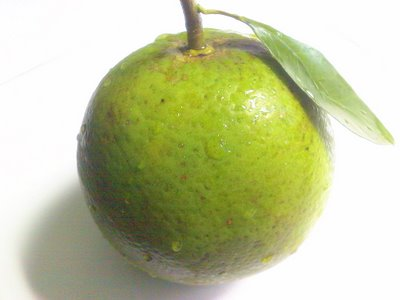

Label: orange


In [ ]:
show_image(errors[0])

On visual inspection, you can see how this might be mistaken for a green apple at first glance even by a human.

**Using other images**

You can even try it with your own images.  Just provide a URI to access an image via the Internet.  If you are running this in a local notebook instead of Colab, you can provide a file path as URI to process images you have locally stored.

In [ ]:
def test_image_uri(user_uri, texts):
  query = Document(
    uri=user_uri,
    matches=[
        Document(text=text)
        for text in texts
    ],
  )
  result = client.rank([query])
  best_match = result[0].matches[0] # the matches are reordered from best to worst by the server
  display(Image(url=user_uri, width=250))
  print(f"Best match: {best_match.text}")
  print(f"Score: {best_match.scores['clip_score'].value}")

test_image_uri("https://upload.wikimedia.org/wikipedia/commons/a/af/5_apples.jpg", ["apple", "orange"])



Try it with other pictures of apples and oranges.  Please don't use excessively large images.

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/3/37/Gammel_dame_kj%C3%B8per_epler.JPG", ["apple", "orange"])

Now, let's see what happens if we give CLIP-as-service and image with both an apple and an orange in it.

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/a/a8/Apple_and_Orange_-_they_do_not_compare.jpg", ["apple", "orange"])

You can see that forcing CLIP to answer with either "apple" or "orange" yields a low score when both apply.  No matter what we give it, it **has to** choose one as more representative of the image than the other.

If a picture has neither apples nor oranges in it, the result is very unreliable:

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/5/55/Banana_%281%29.jpg", ["apple", "orange"])

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/"
"Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/515px-Mona_"
"Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", ["apple", "orange"])

**It is very important to understand that CLIP queries will always select the best fitting of the options you give it.  If none of those options fits, the results will be somewhat random.**

One way to address this is to try to use polar sentences for matching.  For example, 'apple' and 'not apple':

In [ ]:

test_image_uri("https://upload.wikimedia.org/wikipedia/commons/a/af/5_apples.jpg", ["apple", "not apple"])

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/9/92/ATIIIII.jpg", ["apple", "not apple"])

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/5/55/Banana_%281%29.jpg", ["apple", "not apple"])

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci"
"%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", ["apple", "not apple"])

Let's see how accurate it is with the entire apples and oranges dataset:

In [ ]:
# correct the tags to the new class labels
apples_and_not_apples = DocumentArray(
    [
        Document(
            blob=doc.blob,
            tags={'value' : 'apple' if doc.tags['value'] == 'apple' else 'not apple'}
        )
        for doc in apples_and_oranges
    ]
)

labels, errors = clip_classifier(apples_and_not_apples, ["apple", "not apple"])

You can see there are a lot errors! This classifier is only 86.3% accurate.

Let's count the errors per class:

In [ ]:
total_counts = {'apple':0, 'not apple':0}
for doc in apples_and_not_apples:
  total_counts[doc.tags['value']] += 1

error_counts = {'apple':0, 'not apple':0}
for doc in errors:
  error_counts[doc.tags['value']] += 1
print(f"apple errors:\t{error_counts['apple']} out of {total_counts['apple']}")
print(f"orange errors:\t{error_counts['not apple']} out of {total_counts['not apple']}")

apple errors:	23 out of 88
orange errors:	1 out of 88


The errors are very asymetric. Only one orange was identified as an apple, but many apples were identified as 'not apple'.

This is because the text 'apple' and 'not apple' are very similar from the perspective of the neural network.  **CLIP does not handle negation the way people do, and it's much more reliable to give it positive statements to identify with.**

Instead of using 'not', let's try a different pair of contrasts: 'apple' and 'fruit':

In [ ]:
# correct the tags to the new class labels
apples_and_fruit = DocumentArray(
    [
        Document(
            blob=doc.blob,
            tags={'value' : 'apple' if doc.tags['value'] == 'apple' else 'fruit'}
        )
        for doc in apples_and_oranges
    ]
)

labels, errors = clip_classifier(apples_and_fruit, ["apple", "fruit"])

Using this constrast, there are far fewer errors.  Accuracy is 97.2%.  Pictures of oranges match "fruit" better than "not apple".

Let's look at the errors:

In [ ]:
for error in errors:
  show_image(error)
  print(f"Predicted label: {error.matches[0].text}")

Most of the errors are apples that match "fruit" better than "apple", according to CLIP, and one very anomalous orange.

But we still have the problem that any picture that's not fruit at all is still going to be labeled as either an apple or some kind of fruit.  For example:

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci"
"%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", ["apple", "fruit"])

Best match: fruit
Score: 0.5066827535629272


We can resolve this by adding different "control" words that describe images more generally.  Like "picture""

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci"
"%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", ["apple", "picture"])

Let's try it with the apple and orange pictures:

In [ ]:
# correct the tags to the new class labels
apples_and_other = DocumentArray(
    [
        Document(
            blob=doc.blob,
            tags={'value' : 'apple' if doc.tags['value'] == 'apple' else 'picture'}
        )
        for doc in apples_and_oranges
    ]
)


labels, errors = clip_classifier(apples_and_other, ["apple", "picture"])

Using "picture" instead of "fruit" to contrast to "apple" produces a lot more errors.

In [ ]:
for error in errors:
  show_image(error)
  print(f"Predicted label: {error.matches[0].text}")

Quite a few pictures of oranges match "apple" better than "picture", according to CLIP. But what happens if we contrast "apple" with BOTH "picture" and "fruit"?

To do this, we need to modify the `clip_classifier` method to just test for apples and ignore other categories:

In [ ]:
def apple_classifier(data, matches):
  # first we break the data into batches of ten
  batches = [data[i:i+10] for i in range(0, len(data), 10)]

  label_predictions = []
  errors = []

  # we iterate over the batches, sending them to CLIP-as-service
  for batch_num, batch in enumerate(batches):
    print(f"Processing batch #{batch_num}. Errors so far: {len(errors)}")
    queries = []
    for doc in batch:
      queries.append(
          Document(
              blob=doc.blob,
              tags=doc.tags,
              matches=[Document(text=m) for m in matches],
          )
      )
    results = client.rank(queries)
    for result_doc in results:
      label_predictions.append((result_doc.tags['value'], result_doc.matches[0].text))
      if result_doc.tags['value'] ==  "apple" and result_doc.matches[0].text != "apple":
        errors.append(result_doc)
    if result_doc.tags['value'] !=  "apple" and result_doc.matches[0].text == "apple":
        errors.append(result_doc)
        
  print(f"Total processed: {len(label_predictions)}")
  print(f"Errors: {len(errors)}")
  return label_predictions, errors

labels, errors = apple_classifier(apples_and_oranges, ["apple", "fruit", "picture"])

This reduces the errors by quite a lot compared to contrasting "apple" with "picture", but only a little bit compared to "apple" and "fruit".

In [ ]:
for error in errors:
  show_image(error)
  print(f"Predicted label: {error.matches[0].text}")

However, we can reasonably reliably filter out images that are neither "fruit" nor "apple":

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci"
"%2C_from_C2RMF_retouched.jpg/515px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg", ["apple", "fruit", "picture"])

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/6/6f/Macropodus_opercularis_-_side_%28aka%29.jpg", ["apple", "fruit", "picture"])

In [ ]:
test_image_uri("https://upload.wikimedia.org/wikipedia/commons/b/bd/Spaghetti_%284623718139%29.jpg", ["apple", "fruit", "picture"])

By experimenting with the contrasting texts you use, you can use CLIP-as-service to get very good image classification results **without any programming at all**.

# Powerful features for image analysis

In addition to classifying scenes and objects in images, CLIP-as-service can analyse the number of items in an image and their relative locations. 



In [ ]:
# If you ran the previous section, you can skip this part
from docarray import DocumentArray, Document
from IPython.display import Image

# This function is already defined if you ran the previous section
def show_scores(result_document):
  print("Score     \tText")
  print("----------\t----------")
  for proposed_match in result_document.matches:
    print("{:.8f}".format(proposed_match.scores['clip_score'].value) + "\t" + proposed_match.text)

def show_image(doc):
  fmt = None
  if doc.mime_type and doc.mime_type.startswith("image/"):
    fmt = doc.mime_type[6:].strip()
  display(Image(data=doc.blob, width=250, format=fmt))
  print(f"Label: {doc.tags['value']}")

apples_and_oranges = DocumentArray.pull("apples_and_oranges", show_progress=True)
print("Done loading!")

## Counting objects

You can use CLIP-as-service to count objects in images using natural language. Let's define a function to do so by using the same query interface used above to tell apples from oranges:

In [ ]:
def count_apples(image):
    query = Document(
        blob=image.blob,
        matches=[
            Document(text="orange"),
            Document(text="one apple"),
            Document(text="two apples"),
            Document(text="three apples"),
            Document(text="four or more apples"),
        ],
        tags=image.tags
    )
    result = client.rank([query])
    show_image(query)
    print()
    show_scores(result[0])
    print()

Let's test this on images with more than one apple:

In [ ]:
count_apples(apples_and_oranges[0])
count_apples(apples_and_oranges[32])
count_apples(apples_and_oranges[172])
count_apples(apples_and_oranges[173])

This approach to counting becomes unreliable with more than three or four things to count.

## Spatial Relations

CLIP-as-service can also detect some spatial relationships.  For example, is the apple in front of or behind the grapes?

In [ ]:
image = Document(uri="https://upload.wikimedia.org/wikipedia/commons/0/00/Grapes_and_apple.jpg", tags={'value': 'label'})
image.load_uri_to_blob()

query = Document(
    blob=image.blob,
    matches=[
        Document(text="the apple is in front of the grapes"),
        Document(text="the apple is behind the grapes"),
        
    ],
    tags=image.tags
)
result = client.rank([query])
display(Image(data=query.blob, width=250))
print()
show_scores(result[0])

In [ ]:
image = Document(uri="https://upload.wikimedia.org/wikipedia/commons/f/f5/2016-09-15_04-25-35_recup.jpg", tags={'value': 'label'})
image.load_uri_to_blob()

query = Document(
    blob=image.blob,
    matches=[
        Document(text="the apple is between the pears and the banana"),
        Document(text="the bananas are between the apple and the pears"),
        
    ],
    tags=image.tags
)
result = client.rank([query])
display(Image(data=query.blob, width=250))
print()
show_scores(result[0])

# Using CLIP-as-service to do local image search

Another out-of-the-box application of CLIP-as-service is perform searches on locally stored image data, accessing the server only to encode the image data and the queries, while using JINA locally to search.

In [ ]:
# You can skip this if you have done any of the previous sections
from docarray import DocumentArray, Document
from IPython.display import Image

# This function is already defined if you ran the previous section
def show_scores(result_document):
  print("Score     \tText")
  print("----------\t----------")
  for proposed_match in result_document.matches:
    print("{:.8f}".format(proposed_match.scores['clip_score'].value) + "\t" + proposed_match.text)

def show_image(doc):
  fmt = None
  if doc.mime_type and doc.mime_type.startswith("image/"):
    fmt = doc.mime_type[6:].strip()
  display(Image(data=doc.blob, width=250, format=fmt))
  print(f"Label: {doc.tags['value']}")

apples_and_oranges = DocumentArray.pull("apples_and_oranges", show_progress=True)
print("Done loading!")

CLIP works by encoding images and texts into vectors, using a trained neural network. We can then compare these encodings directly.

First, we will encode all the images in `apples_and_oranges`.  This may take several minutes.



In [ ]:
import time, jina

def encode_apples_and_oranges():
  encoded_apples_and_oranges = []
  batchsize = 4
  def _add(i, j):
      if j >= 3:
          raise Exception("Can't complete encoding due to server interruptions!")
      try:
          encoded_apples_and_oranges.extend(client.encode(apples_and_oranges[i:i+batchsize]))
      except jina.excepts.BadClient:
          print(f"fail {j+1}")
          time.sleep(5)
          _add(i, j+1)
          
  for i in range(0, len(apples_and_oranges), batchsize):
      _add(i, 0)
      if i and i%10 == 0:
        print("{:.2f}% done".format(100.0*i/len(apples_and_oranges)))
  
  print("Done encoding!")
  return DocumentArray(encoded_apples_and_oranges)

encoded_images = encode_apples_and_oranges()
        

You can see that the server has assigned a vector to each image by looking at the `embedding` field in each member of `encoded_images`:

In [ ]:
encoded_images[0].embedding

Now, let's use CLIP-as-service to encode a text query. In this case, for green apples:

In [ ]:
query = client.encode([Document(text="green apple")])[0]

You can see that query also has an assigned vector in the `embedding` field:

In [ ]:
query.embedding

Now we can use a local function in the `DocumentArray` object to find matches in `encoded_images` without invoking the CLIP-as-service server:

In [ ]:
result = encoded_images.find(query, limit=5)[0]

The optional `limit` argument restricts the number of items returned. The result should be the same length as `limit`:

In [ ]:
len(result)

5

Let's look at the images found:

In [ ]:
for found_image in result:
  show_image(found_image)

Or alternately, we could search for images of cut oranges:

In [ ]:
query = client.encode([Document(text="cut orange")])[0]
result = encoded_images.find(query, limit=5)[0]
for found_image in result:
  show_image(found_image)

Furthermore, you can use the encodings of images to search for similar images.

Let's take an image of an orange from another source and encode it:

In [ ]:
outside_image = Document(uri="https://upload.wikimedia.org/wikipedia/commons/9/9e/Single_Orange_%28Fruit%29.jpg", tags={'value': 'orange'})
outside_image.load_uri_to_blob()
show_image(outside_image)
image_query = client.encode([outside_image])[0]

Now we're going to use that encoding as a query:

In [ ]:
result = encoded_images.find(image_query, limit=5)[0]
for found_image in result:
  show_image(found_image)

Using CLIP-as-service this way, you search local image repositories, using texts or images as queries. The service encodes locally stored objects just once, and then encodes each new query, minimizing the number of calls to the service.